In [1]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")

missing_counts = train_df.isnull().sum()
print("Columns with any missing values (train):")
print(missing_counts[missing_counts > 0].sort_values(ascending=False))

# Drop columns that have very high missingness ( > 50% missing)
high_missing_cols = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"]

train_df = train_df.drop(columns=high_missing_cols)
test_df  = test_df.drop(columns=high_missing_cols)

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape    : {test_df.shape}")


Columns with any missing values (train):
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64
Training set shape: (1460, 76)
Test set shape    : (1459, 75)


In [2]:
# fill the remained missing values 

target = "SalePrice"                    
num_cols = [c for c in train_df.select_dtypes(include=["int64", "float64"]).columns if c != target]              
cat_cols = train_df.select_dtypes(include=["object"]).columns

for col in num_cols:
    median_val = train_df[col].median()
    train_df[col] = train_df[col].fillna(median_val)
    if col in test_df.columns:           # guard against KeyError
        test_df[col]  = test_df[col].fillna(median_val)

for col in cat_cols:
    mode_val = train_df[col].mode()[0] if not train_df[col].mode().empty else "None"
    train_df[col] = train_df[col].fillna(mode_val)
    if col in test_df.columns:
        test_df[col]  = test_df[col].fillna(mode_val)

print("Missing values remaining — train:", train_df.isnull().sum().sum(),
      " | test:",  test_df.isnull().sum().sum())


Missing values remaining — train: 0  | test: 0


In [4]:
# one‑hot‑encoding for all categorical features

target   = "SalePrice"
id_col   = "Id"          

combined = pd.concat(
    [train_df.drop(columns=[target]), test_df],
    axis=0,
    keys=["train", "test"]
)

combined_encoded = pd.get_dummies(combined, drop_first=True)

X_train = combined_encoded.xs("train")
X_test  = combined_encoded.xs("test")
y_train = train_df[target]

if id_col in X_train.columns:
    X_train = X_train.drop(columns=[id_col])
    X_test  = X_test.drop(columns=[id_col])

print("Encoded shapes →  X_train:", X_train.shape,
      "| X_test:", X_test.shape,
      "| y_train:", y_train.shape)


Encoded shapes →  X_train: (1460, 231) | X_test: (1459, 231) | y_train: (1460,)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42)

lr = LinearRegression()
lr.fit(X_tr, y_tr)

val_pred = lr.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_pred))
print(f"Validation RMSE: {rmse:.2f}")

lr.fit(X_train, y_train)

test_predictions = lr.predict(X_test)

submission = pd.DataFrame({
    "Id": test_df["Id"], 
    "SalePrice": test_predictions
})

submission.to_csv("submission.csv", index=False)
print("→ Saved predictions to submission.csv")


Validation RMSE: 51994.73
→ Saved predictions to submission.csv


In [9]:
from sklearn.metrics import r2_score

val_pred = lr.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_pred))
r2 = r2_score(y_val, val_pred)

print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation R²: {r2:.4f}")


Validation RMSE: 22976.90
Validation R²: 0.9312


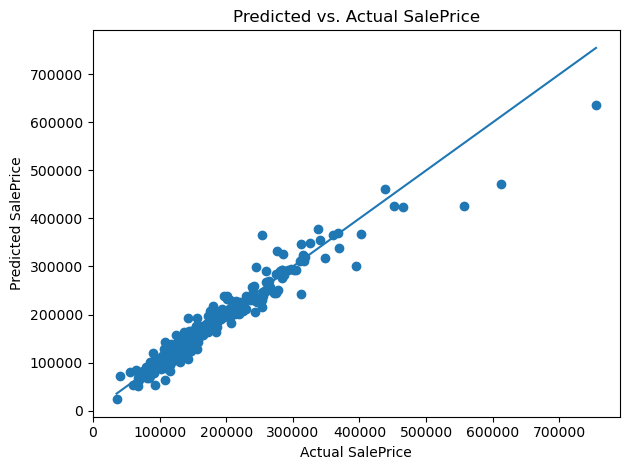

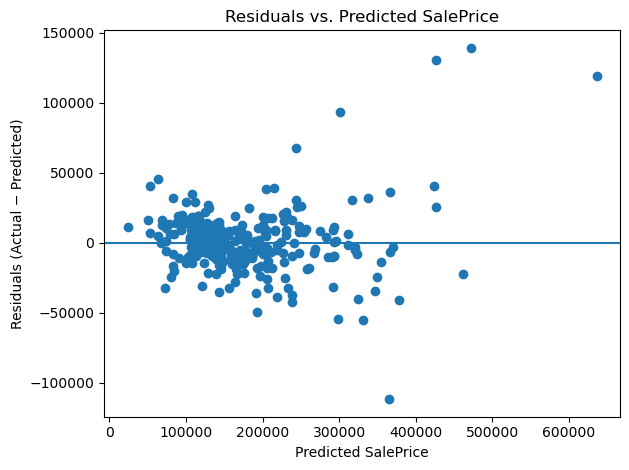

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# ---- 1. Predicted vs. Actual scatter --------------------------------
plt.figure()
plt.scatter(y_val, val_pred)                               # dots
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()])                       # 45° line
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Predicted vs. Actual SalePrice")
plt.tight_layout()
plt.show()

# ---- 2. Residuals vs. Predicted scatter ------------------------------
residuals = y_val - val_pred
plt.figure()
plt.scatter(val_pred, residuals)
plt.axhline(0)                                             # zero line
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals (Actual − Predicted)")
plt.title("Residuals vs. Predicted SalePrice")
plt.tight_layout()
plt.show()
